# Problem 1 Model
A notebook containing the models for Problem 1. A credit risk analyst is using previous loan data to predict if some current loans are going to be default or not and if they are, calculate the recoveries based on them.

It includes two classification models, one predicting if the loan will be default ('default_ind'), and one for recoveries being zero or non-zero, and a regression model predicting the value of the non-zero recoveries.

In [2]:
#Imports

#Data
import pandas as pd
import numpy as np

#Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

#ML

#General
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import RandomizedSearchCV
import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

#Classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


#Regression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
from sklearn.neural_network import MLPRegressor

In [3]:
#Getting the csv file's name with the wrangled data
data_file='wrang_xyz_data.csv'

#Splitting the data into different categories that make sense
loan_data=['purpose','initial_list_status','term','revol_bal','loan_amnt','total_rev_hi_lim']
emp_data=['emp_length','collections_12_mths_ex_med','acc_now_delinq','home_ownership','annual_inc','verification_status','zip_code','addr_state','delinq_2yrs','inq_last_6mths','open_acc','pub_rec','total_acc','earliest_cr_line','dti','tot_coll_amt','tot_cur_bal','revol_util']
out=['last_pymnt_amnt','total_pymnt','total_rec_int','int_rate','out_prncp','total_rec_late_fee']

#Getting the features that will be included in the model
features=loan_data+emp_data+out
#out_old=['last_pymnt_d','last_credit_pull_d','recoveries','collection_recovery_fee','last_pymnt_amnt','total_pymnt','total_rec_int','int_rate','out_prncp',total_rec_late_fee','default_ind']

[[11465    83]
 [  447 11239]]
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     11548
           1       0.99      0.96      0.98     11686

    accuracy                           0.98     23234
   macro avg       0.98      0.98      0.98     23234
weighted avg       0.98      0.98      0.98     23234



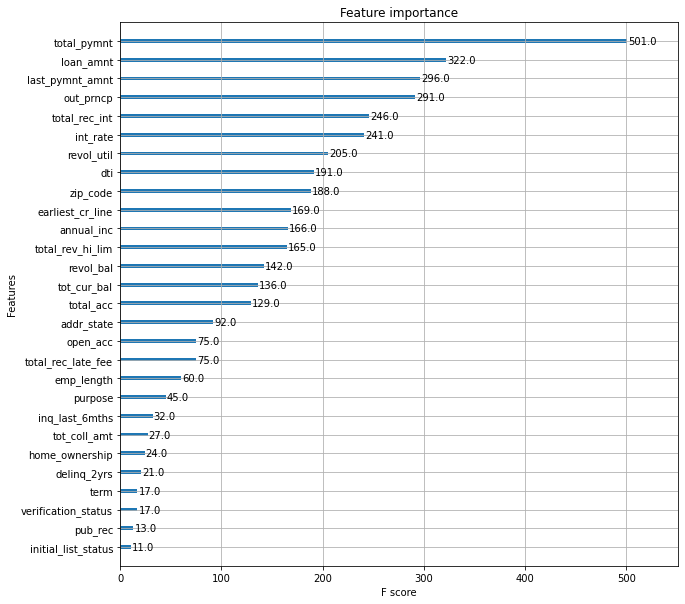

In [6]:
#Classification model predicting default_ind for problem 1
#The model's inputs are the data_file which should be set equal to the wrangled data file, the way to train test split
#date does it according to  date, otherwise it is random and the algorithm used for the model 

def get_model_class(data_file='wrang_xyz_data.csv',split='date',model_type='xgb'):
    #Imporitng the wrangled csv file and including the useful columns for it
    pred_data=['issue_d','default_ind']
    df = pd.read_csv('data/'+data_file,usecols=features+pred_data)

    #Selecting train test split method to be random
    if split=='random':
        #Creating X and y variables for input and output
        X=df.drop(['default_ind','issue_d'],axis=1)
        y=df['default_ind']

        #Undersampling the data to create a more balanced dataset
        undersample = RandomUnderSampler(sampling_strategy='majority')
        X,y = undersample.fit_resample(X, y)

        #Splitting the data into train and test
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, test_size=0.25)

    #Selecting train test split method to be done based on date
    else:
        #Creating X and y variables for input and output
        X=df.drop('default_ind',axis=1)
        y=df[['default_ind','issue_d']]

        #Splitting the dataset according to date
        X_train=X[X['issue_d']<=20150501].drop('issue_d',axis=1)
        X_test=X[X['issue_d']>20150501].drop('issue_d',axis=1)

        y_train=y[y['issue_d']<=20150501]['default_ind']
        y_test=y[y['issue_d']>20150501]['default_ind']

        #Undersampling the data to create a more balanced dataset
        undersample = RandomUnderSampler(sampling_strategy='majority')
        X_train,y_train = undersample.fit_resample(X_train, y_train)
        X_test,y_test = undersample.fit_resample(X_test, y_test)

    #Selecting xgboost algorithm
    if model_type=='xgb':
        model_class = xgb.XGBClassifier(use_label_encoder=False,eval_metric='logloss')
        model_class.fit(X_train,np.ravel(y_train))

        #Plotting feature importance
        fig, ax = plt.subplots(figsize=(10,10))
        xgb.plot_importance(model_class,importance_type='weight', ax=ax)

    #Selecting logistic regression model
    elif model_type=='lg_reg':
        model_class=LogisticRegression(max_iter=10*6)
        model_class.fit(X_train,np.ravel(y_train))

    #Selecting random forest model
    else: 
        model_class = RandomForestClassifier()
        model_class.fit(X_train,np.ravel(y_train))

    #Predicting values and printing confusion matrix and classification report
    y_class_pred = model_class.predict(X_test)
    print(confusion_matrix(y_test, y_class_pred))
    print(classification_report(y_test, y_class_pred))


    return model_class

#Running the function
model_class=get_model_class(split='random',model_type='xgb')

[[5844  214]
 [  53 5983]]
              precision    recall  f1-score   support

         0.0       0.99      0.96      0.98      6058
         1.0       0.97      0.99      0.98      6036

    accuracy                           0.98     12094
   macro avg       0.98      0.98      0.98     12094
weighted avg       0.98      0.98      0.98     12094



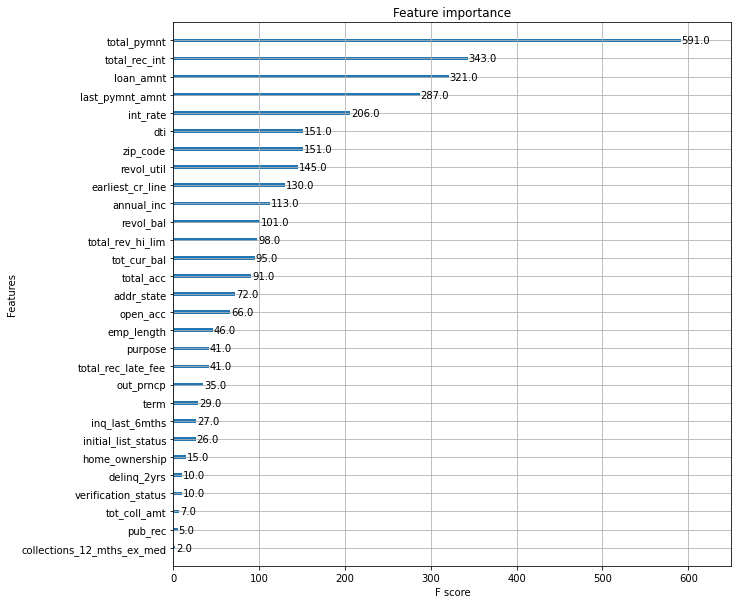

In [7]:
#Classification model predicting zero or non-zero recoveries for problem 1
#The model's inputs are the data_file which should be set equal to the wrangled data file
#and the algorithm used for the model 

def get_model_class(data_file='wrang_xyz_data.csv',model_type='xgb'):
    #Imporitng the wrangled csv file and including the useful columns for it
    pred_data=['default_ind','recoveries','collection_recovery_fee']
    df = pd.read_csv('data/'+data_file,usecols=features+pred_data)

    #Getting only the cases that the loan is default
    df=df[df['default_ind']==1].drop('default_ind',axis=1)

    #Combining recoveries and recovery fees
    df['recoveries']=df['recoveries']+df['collection_recovery_fee']

    #Substituting all non-zero recoveries to 1
    df['recoveries']=df['recoveries'].where(df['recoveries']==0,1)
    df=df.drop('collection_recovery_fee',axis=1)
    
    #Creating X and y variables for input and output
    X=df.drop('recoveries',axis=1)
    y=df['recoveries']

    #Undersampling the data to create a more balanced dataset  
    undersample = RandomUnderSampler(sampling_strategy='majority')
    X,y = undersample.fit_resample(X, y)

    #Splitting the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, test_size=0.25)

    #Selecting xgboost algorithm
    if model_type=='xgb':
        model_class = xgb.XGBClassifier(use_label_encoder=False,eval_metric='logloss')
        model_class.fit(X_train,np.ravel(y_train))

        #Plotting feature importance 
        fig, ax = plt.subplots(figsize=(10,10))
        xgb.plot_importance(model_class,importance_type='weight', ax=ax)

    #Selecting logistic regression algorithm
    elif model_type=='lg_reg':
        model_class=LogisticRegression(max_iter=10*6)
        model_class.fit(X_train,np.ravel(y_train))

    #Selecting random forest algorithm
    else: 
        model_class = RandomForestClassifier()
        model_class.fit(X_train,np.ravel(y_train))

    #Predicting values and printing confusion matrix and classification report
    y_class_pred = model_class.predict(X_test)
    print(confusion_matrix(y_test, y_class_pred))
    print(classification_report(y_test, y_class_pred))

    return model_class
#Running the function
model_class=get_model_class(model_type='xgb')

In [10]:
#Regression model predicting recoveries for problem 1
#The model's inputs are the data_file which should be set equal to the wrangled data file,
#the algorithm used for the model, the value to be predicted and if hyperparameter tuning
#investigation should be run on the model.

def get_model_reg(data_file='wrang_xyz_data.csv',model_type='xgb',pred_value=['recoveries'],hyper_tune='no'):
    #Imporitng the wrangled csv file and including the useful columns for it
    pred_data=['collection_recovery_fee']
    df = pd.read_csv('data/'+data_file,usecols=features+pred_data+pred_value)

    #Combining recoveries and recovery fees
    df['recoveries']=df['recoveries']+df['collection_recovery_fee']

    #Getting only non-zero recoveries
    df=df[df['recoveries']!=0].drop('collection_recovery_fee',axis=1)
    
    #Creating X and y variables for input and output
    X=df.drop(pred_value[0],axis=1)
    y=df[pred_value[0]]

    #Splitting the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, test_size=0.25)

   
    #Selecting xgboost algorithm
    if model_type=='xgb':

        #Selecting random hyperparameter tuning investigation
        if hyper_tune=='random':

            #Establishing Parameters
            params = { 'max_depth': [3, 5, 6, 10, 15, 20],
            'learning_rate': [0.01, 0.1, 0.2, 0.3],
            'subsample': np.arange(0.5, 1.0, 0.1),
            'colsample_bytree': np.arange(0.4, 1.0, 0.1),
            'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
            'n_estimators': [100, 500, 1000]}

            #Running xgboost model for different parameter combinations based on r-sqaured
            model_reg = xgb.XGBRegressor()

            model_reg = RandomizedSearchCV(estimator=model_reg,
                            param_distributions=params,
                            scoring='r2',
                            n_iter=25,
                            verbose=1)
            model_reg.fit(X_train,np.ravel(y_train))

            #Printing best parameters and r2
            print("Best parameters:", model_reg.best_params_)
            print("Lowest RMSE: ", (model_reg.best_score_))

        #Selecting grid hyperparameter tuning investigation
        elif hyper_tune=='grid':

            #Establishing Parameters
            params = { 'max_depth': [3,6,10],
           'learning_rate': [0.01, 0.05, 0.1],
           'n_estimators': [100, 500, 1000],
           'colsample_bytree': [0.3, 0.7]}

           #Running xgboost model for different parameter combinations based on negative mean squared error
            model_reg = xgb.XGBRegressor() 
            model_reg = GridSearchCV(estimator=model_reg, 
                            param_grid=params,
                            scoring='neg_mean_squared_error', 
                            verbose=1)
                    
            model_reg.fit(X_train,np.ravel(y_train))

            #Printing best parameters and negative mean squared error
            print("Best parameters:", model_reg.best_params_)
            print("Lowest RMSE: ", (-model_reg.best_score_)**(1/2.0))

        #Runs the model normally
        else:
            model_reg = xgb.XGBRegressor() #max_depth=3,learning_rate=0.01,colsample_bytree=0.7,n_estimators=100
            model_reg.fit(X_train,np.ravel(y_train))

    #Selecting linear regression algorithm
    elif model_type=='lin_reg':
        model_reg=LinearRegression()
        model_reg.fit(X_train,np.ravel(y_train))

    #Selecting knn regression algorithm
    elif model_type=='knn':
        model_reg=KNeighborsRegressor(n_neighbors=1)
        model_reg.fit(X_train,np.ravel(y_train))

    #Selecting random forest regression algorithm
    elif model_type=='ran_for': 
        model_reg = RandomForestRegressor(n_estimators=200)
        model_reg.fit(X_train,np.ravel(y_train))
    
    #Selecting Deep Learning regression algorith
    else:
        model_reg = MLPRegressor().fit(X_train, y_train)
        model_reg.fit(X_train,y_train)

    #Predicting values
    y_reg_pred = model_reg.predict(X_test)

    #Getting error metrics
    mse = metrics.mean_squared_error(y_test, y_reg_pred)
    rmse = np.sqrt(mse) # or mse**(0.5)  
    r2 = metrics.r2_score(y_test,y_reg_pred)

    #Creating a custom error field
    error = np.mean(abs(y_test - y_reg_pred)/y_reg_pred)*100

    #Printing error metrics
    print("RMSE:", rmse)
    print("R-Squared:", r2)
    print(error)

    return model_reg

#Running the function    
model_reg=get_model_reg(model_type='xgb',pred_value=['recoveries'],hyper_tune='no')

33.65174950100735
RMSE: 1062.2758403736752
R-Squared: 0.7380701489039476
